In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import sys
from math import pi, sin, cos, tan
from time import sleep

# Find SunFounder_PiCar submodule
sys.path.append("../lib")
sys.path.append("../lib/SunFounder_PiCar")

# Custom libraries
from helpers import sign, angle_a2b, within_pi, clip
from my_pid import myPID
import perspectives 
from cartesian_pose import CartesianPose
from bicycle_model  import BicyclePose, next_pose, dXdt, dYdt, dHdt
from my_picar_utils import PicarHardwareInterface as Hardware 
from my_picar_utils import MyPicarController as Controller
from my_picar_utils import HardwareUnitConverter as Converter 
from my_picar_utils import MyWorldFrame as World 
from my_picar import Picar

In [2]:
def rotmat(theta):
    return np.array([[cos(theta), -sin(theta)], [sin(theta),cos(theta)]])

WIDTH=.8
HEIGHT=1.2
dims = np.array([HEIGHT,WIDTH])
def plot_wp_rects(ax, allposes):
    for pose in allposes:
        xy = pose[:2]
        th = pose[2]
        correction = np.matmul(rotmat(th), dims)/2
        r = mpl.patches.Rectangle(xy, HEIGHT, WIDTH, angle=th*180/pi, zorder=0)
        r.set_xy(xy-correction)
        ax.add_patch(r)
    
def to_cartesian(xyh):
    return CartesianPose(x=xyh[0],y=xyh[1],h=xyh[2])

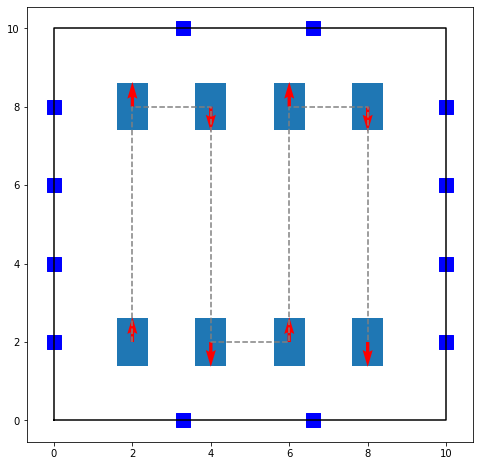

In [3]:
env_lims = np.array([ [0, 10], [0,10] ])

# Coverage strategy: Snake vertically, then horizontally
fig = plt.figure(figsize=(8,8))
plt.plot([0,10,10,0, 0], [0, 0, 10, 10, 0], 'k')
ax = plt.gca()
ax.axis('equal')

QR_codes = {
    "pos" : np.array([ 
                [ 0,   2], [  0,  4], [ 0, 6], [ 0, 8], #left wall
                [ 10,  2], [  10, 4], [10, 6], [10, 8], # right wall
                [3.3,  0], [6.6,  0], # bottom wall
                [3.3, 10], [6.6, 10] # top wall
               ]),
    "id" : np.array([ 1, 2, 2, 1,  # left wall
                      2, 1, 1, 2,  # right wall
                      1, 2,  # bottom wall
                      2, 1   # top wall
                    ])
}


picar_start = np.array([2,2, pi/2])
waypoints = np.array([
    [2,8,  pi/2],
    [4,8, -pi/2],
    [4,2, -pi/2],
    [6,2,  pi/2],
    [6,8,  pi/2],
    [8,8, -pi/2],
    [8,2, -pi/2]
])
allposes = np.insert(waypoints, 0, picar_start, axis=0) 



ax.scatter(QR_codes["pos"][:,0], QR_codes["pos"][:,1], c='b', marker='s', s=200)
plt.plot( allposes[:,0], allposes[:,1], color='gray', ls='--')
plot_wp_rects(ax, allposes)
ax.quiver( allposes[:,0], allposes[:,1], 
           np.cos(allposes[:,2]), np.sin(allposes[:,2]),
           color='r') 

In [4]:

def dist(a,b):
    a = np.array(a)
    b = np.array(b)
    if np.ndim(a)==1:
        a = a[None]
    if np.ndim(b)==1:
        b = b[None]
    return np.squeeze(np.sqrt(np.sum(np.power(a-b,2),axis=1)))

# while ( dist(picar.world_pose, goal) )

In [155]:
import copy
rhoPID   = myPID(Kp=0.3, Kd=0, Ki=0)
alphaPID = myPID(Kp=1, Kd=0, Ki=0)
betaPID  = myPID(Kp=1, Kd=0, Ki=0)
controller = Controller(rhoPID, alphaPID, betaPID)

units = Converter(speed_slope=1/83, angle_slope=-1.2) # Left and right are switched in hardware
picar    = Picar(unit_converter=units, virtual=True)
picar.set_pose(world_pose=to_cartesian(picar_start), goal_pose=to_cartesian(waypoints[0]))
dt = 0.1

def run(picar, waypoints, controller, dt, start_pose=None, ITER_CUTOFF=10000):
    picar = copy.copy(picar)
    if start_pose is not None:
        # if a start pose is provided, set picar._world_pose
        if not isinstance(start_pose, CartesianPose):
            start_pose = to_cartesian(start_pose)
        picar.set_pose(world_pose=start_pose)
    # if a start is not provided, assume picar already set to start_pose
    try:
        for goal in waypoints[1:2]:
            picar.set_pose(goal_pose=to_cartesian(goal))
            i=0
            while ( picar.rho()>0.5 and i < ITER_CUTOFF):
                # Calculate controls
                speed = controller.SPEED(rho=picar.rho(), dt=dt)
                steer = controller.STEER(speed=speed, alpha=picar.alpha(), beta=picar.beta(), L=picar.L)
                direction = controller.DIRECTION(alpha=picar.alpha())
                
                # Apply controls
                speed, steer = picar.drive(speed=speed, steer=steer, direction=direction)

                # Update state
                picar.set_pose(world_pose=picar.next_pose(speed=picar._current_speed, steer=picar._current_steer, 
                                                          direction=picar._current_direction, dt=dt))              
#                 if i % 50 == 0:
#                     print(picar.bicycle_pose(), '\n', picar._current_speed, picar._current_steer, '\n', speed, steer)
#                     print()
                    
                i+=1

            #     sleep(dt)
            print(picar.world_pose(), picar.goal_pose())
    except Exception as e:
        print("Exception occured: {}.\nExiting run()...".format(sys.exc_info()[:-1]))
    finally:
        print(i, picar.rho())
        return picar
    

In [156]:
picar = run(picar, waypoints, controller, dt, start_pose=to_cartesian(waypoints[0]), ITER_CUTOFF=1e3)

CartesianPose: ( 4.477,  7.864,  2.311) CartesianPose: ( 4.000,  8.000, -1.571)
167 0.49605619033558823


In [118]:
print(picar.world_pose(), picar.goal_pose(), '\n', 
      picar.bicycle_pose(), '\n',
      picar._current_speed, picar._current_steer * 180/pi, picar._current_direction, '\n',
     picar.hw._send_speed(picar.hw.unit_converter.speed_world2hardware(picar._current_speed)), 
      picar.hw.unit_converter.angle_world2hardware(picar._current_steer))


CartesianPose: ( 2.000,  8.000,  1.571) CartesianPose: ( 4.000,  8.000, -1.571) 
 BicyclePose: ( 2.000, -1.571, -1.571) 
 0.6 -36.24284307020928 1 
 49.8 30.202369225174404


In [128]:
try:
    b=0
except KeyboardInterrupt as e:
    pass
finally:
    print('boop')

boop
